final

text

Import Libraries

In [44]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Set Global Variables

In [ ]:
# Paths
DATASET_DIR = r"C:\Users\arzua\Downloads\food\food — копия\UECFOOD256"
OUTPUT_DIR = 'processed_dataset'  # Folder where train/val/test splits will be stored
CATEGORY_FILE = r"C:\Users\arzua\Downloads\food\food — копия\category.txt"

# Image dimensions and batch size
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

Dataset Splitting Function

In [38]:
def split_dataset(dataset_dir, output_dir):
    """
    Splits dataset into train, val, and test sets.
    """
    classes = os.listdir(dataset_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
    
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_dir)
        train_images, val_test_images = train_test_split(images, test_size=(VAL_RATIO + TEST_RATIO))
        val_images, test_images = train_test_split(val_test_images, test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)))

        for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for image in split_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(split_class_dir, image))
    
    print("Dataset split complete!")


# Run dataset splitting
split_dataset(DATASET_DIR, OUTPUT_DIR)

Dataset split complete!


Data Generator Function and Train, Validation, and Test Generators

In [39]:
def generator(data_dir, batch_size, image_height, image_width):
    """
    Creates a data generator for the given directory.
    """
    datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values to [0, 1]
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    return generator



# Paths to the split datasets
train_dir = os.path.join(OUTPUT_DIR, 'train')
val_dir = os.path.join(OUTPUT_DIR, 'val')
test_dir = os.path.join(OUTPUT_DIR, 'test')  # Optional

# Create generators
train_gen = generator(train_dir, BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)
val_gen = generator(val_dir, BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)
test_gen = generator(test_dir, BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)  # Optional



# Access one batch of data
for batch_images, batch_labels in train_gen:
    print(f"Batch Images Shape: {batch_images.shape}")
    print(f"Batch Labels Shape: {batch_labels.shape}")
    break

Found 21840 images belonging to 256 classes.
Found 6272 images belonging to 256 classes.
Found 3283 images belonging to 256 classes.
Batch Images Shape: (32, 224, 224, 3)
Batch Labels Shape: (32, 256)


Some Images from Dataset

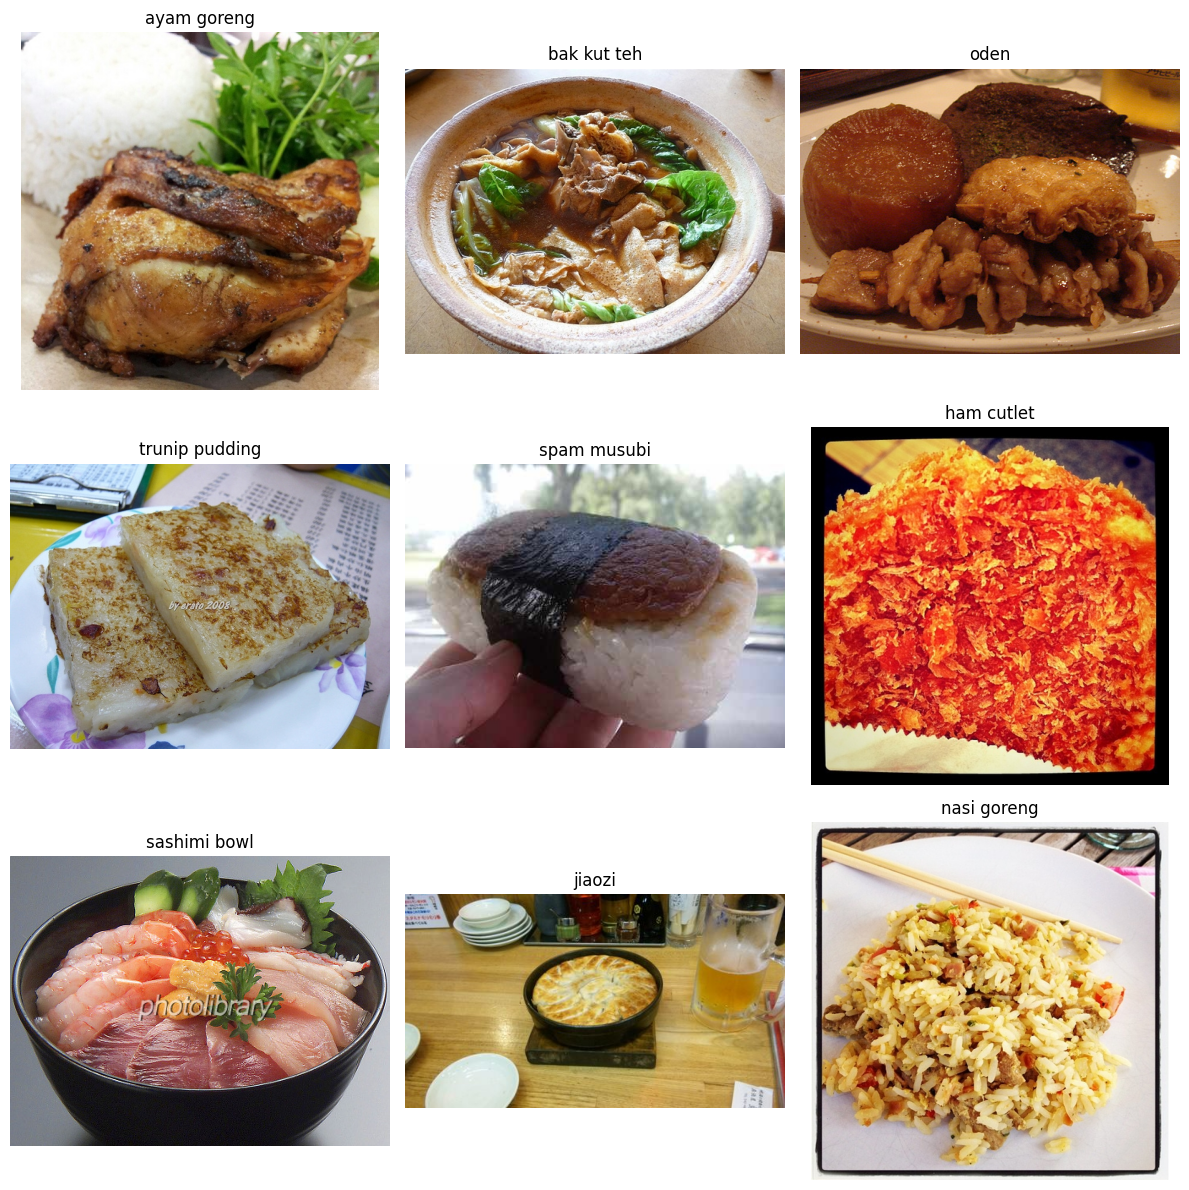

In [40]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to load categories from category.txt
def load_categories(filepath):
    categories = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file.readlines()[1:]:  # Skip the header line
            class_id, class_name = line.strip().split('\t')
            categories[int(class_id)] = class_name
    return categories

# Function to display sample images
def display_sample_images(dataset_dir, categories, num_images=9):
    """
    Displays sample images from the dataset with category names.

    Parameters:
        dataset_dir (str): Path to the dataset directory.
        categories (dict): Dictionary mapping class IDs to category names.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(12, 12))
    all_classes = os.listdir(dataset_dir)
    
    for i in range(num_images):
        # Randomly select a class
        class_id = random.choice(all_classes)
        class_id = int(class_id)  # Convert to integer to match category IDs
        
        # Get the corresponding category name
        category_name = categories[class_id]
        
        # Select a random image from the class folder
        class_path = os.path.join(dataset_dir, str(class_id))
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)
        
        # Open and display the image
        img = Image.open(image_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(category_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


# Load categories and display images
categories = load_categories(CATEGORY_FILE)
display_sample_images(DATASET_DIR, categories)

CNN Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model(input_shape, num_classes):
    """
    Defines and compiles a simple CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Number of classes
num_classes = len(os.listdir(train_dir))

# Create the model
model = create_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=num_classes)

# Summary of the model
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,940,416 (91.33 MB)

 Trainable params: 23,940,416 (91.33 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [48]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
)

Epoch 1/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 295s 431ms/step - accuracy: 0.0220 - loss: 5.4910 - val_accuracy: 0.0233 - val_loss: 5.4866
Epoch 2/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 296s 433ms/step - accuracy: 0.0245 - loss: 5.4795 - val_accuracy: 0.0225 - val_loss: 5.4002
Epoch 3/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 319s 467ms/step - accuracy: 0.0232 - loss: 5.3706 - val_accuracy: 0.0257 - val_loss: 5.3024
Epoch 4/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 297s 435ms/step - accuracy: 0.0293 - loss: 5.2180 - val_accuracy: 0.0287 - val_loss: 5.2384
Epoch 5/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 317s 464ms/step - accuracy: 0.0440 - loss: 4.9730 - val_accuracy: 0.0319 - val_loss: 5.2288


Evaluate the Model

In [49]:
if test_gen:
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.0307 - loss: 5.2426
Test Loss: 5.2205
Test Accuracy: 0.0317


Save the Model

In [50]:
# Save the trained model
model.save('image_classification_model.h5')
print("Model saved as 'image_classification_model.h5'")

Model saved as 'image_classification_model.h5'


Visualization of the Training Process

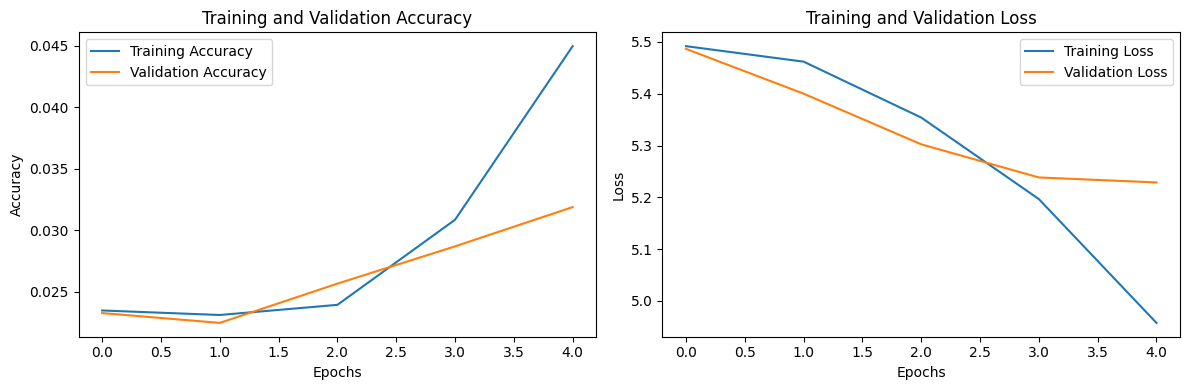

In [51]:
import matplotlib.pyplot as plt

# Visualize training process
def plot_training(history):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training(history)

Visualization of the Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


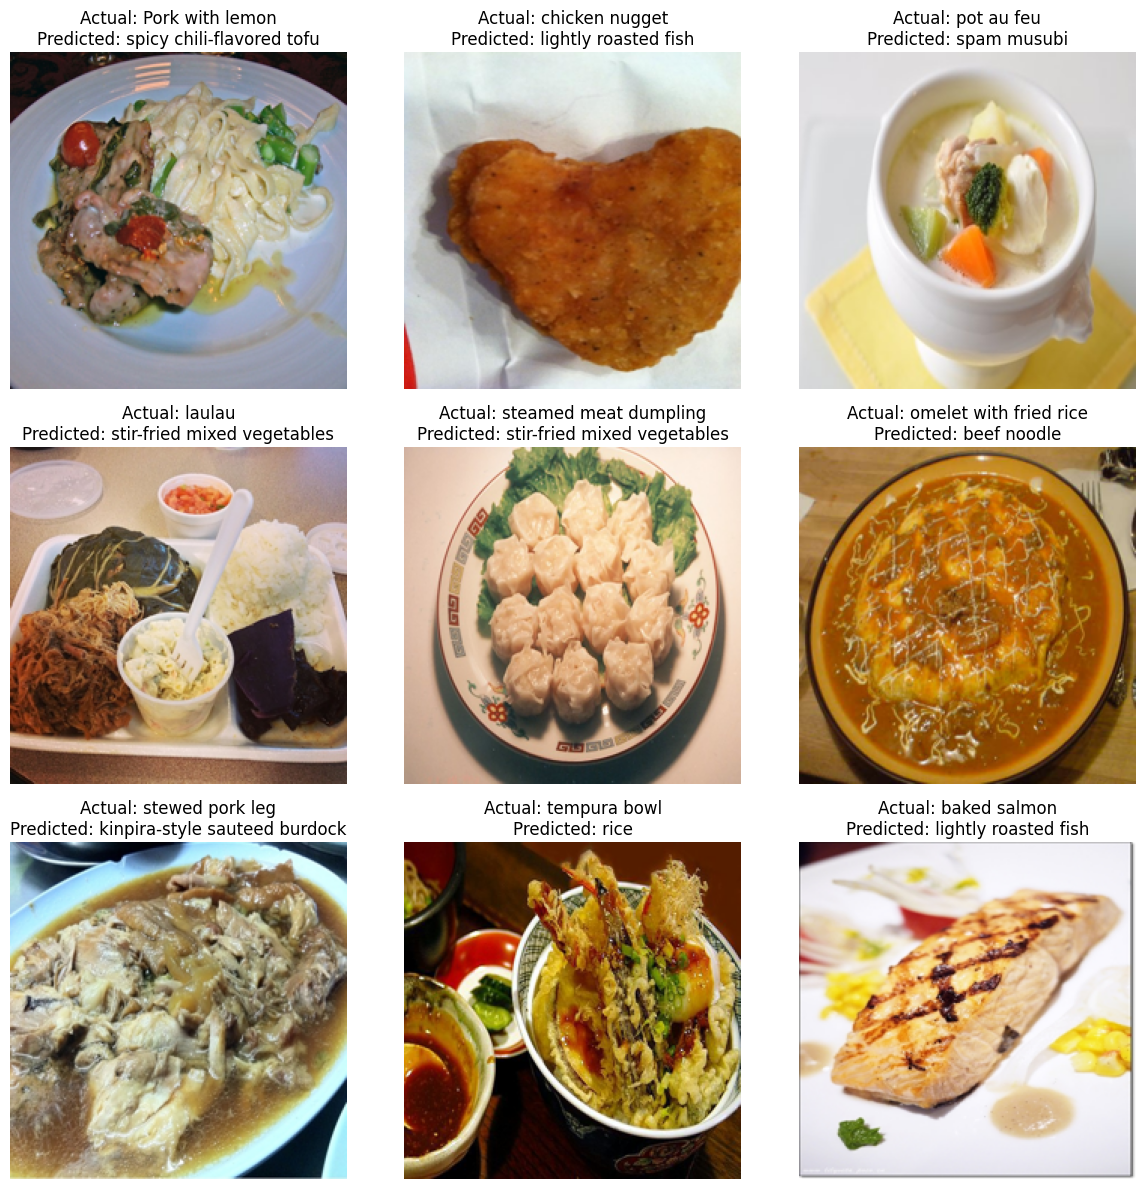

In [52]:
# Function to display images with predicted and actual names
def display_predictions(model, dataset_dir, categories, num_images=5):
    """
    Displays images with predicted and actual category names.

    Parameters:
        model: Trained model to use for predictions.
        dataset_dir (str): Path to the dataset directory.
        categories (dict): Dictionary mapping class IDs to category names.
        num_images (int): Number of images to display.
    """
    import numpy as np

    plt.figure(figsize=(12, 12))
    all_classes = os.listdir(dataset_dir)
    
    for i in range(num_images):
        # Randomly select a class
        class_id = random.choice(all_classes)
        class_id = int(class_id)  # Convert to integer to match category IDs
        
        # Get the corresponding category name
        actual_category_name = categories[class_id]
        
        # Select a random image from the class folder
        class_path = os.path.join(dataset_dir, str(class_id))
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)
        
        # Open and preprocess the image for prediction
        img = Image.open(image_path).resize((224, 224))
        img_array = np.array(img) / 255.0  # Normalize the image
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Get prediction
        predictions = model.predict(img_array)
        predicted_class_id = np.argmax(predictions)
        predicted_category_name = categories[predicted_class_id + 1]  # Adjust index (model outputs 0-based classes)
        
        # Display the image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_category_name}\nPredicted: {predicted_category_name}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function to display predictions
display_predictions(model, DATASET_DIR, categories, num_images=9)